In [2]:
#%pylab widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import copy
from scipy.spatial import KDTree

In [3]:
class Particles:
    def __init__(self, n, scatter=0.01, boxsize=1, periodic=False, seed=12345):
        #book-keeping
        self.n=n
        self.scatter=scatter
        self.boxsize=1
        self.periodic=periodic
        #initialize randomly with seed 
        self.rand=np.random.default_rng(seed)
        self.X=self.rand.uniform(size=[2,n])
        self.Infected=np.zeros(self.n, dtype=int) #0: healthy; 1: primary source; 2: secondary
        self.infect_dist=0.

    def walk(self):
        step=self.rand.normal(0, self.scatter, [2,self.n]) #generate a random step
        self.X+=step
        if self.periodic:
            self.X%=self.boxsize   #periodic boundary
    
    def build_tree(self):
        if self.periodic:
            self.tree=KDTree(self.X.T, boxsize=self.boxsize)
        else:
            self.tree=KDTree(self.X.T)
    
    def spread_from(self, i, dist):
        '''spread the infection from particle i'''
        #ngbrs=self.tree.query_ball_point(self.X.T[i], dist)
        ngbrs=self.tree.query_ball_point(self.X.T[i], dist, workers=4)
        for j in ngbrs:
            if self.Infected[j]<2: #not freshly infected
                self.Infected[j]=2 #tag as secondary infection
                self.spread_from(j, dist)
        
    def infect(self):
        '''tag all particles within dist from infected particles as infected'''
        if self.infect_dist==0. or np.all(self.Infected==0):
            return
    
        self.build_tree()
        self.Infected[self.Infected>0]=1 #set all infected as primary
        for i in range(self.n):
            if self.Infected[i]==1: #primary
                self.spread_from(i, self.infect_dist)
                
    def seed_infection(self, seeds=[0], dist=0.1):
        '''initialize the infection, with particles listed in seeds get infected as well as their close neighbours within dist'''
        self.Infected=np.zeros_like(self.Infected)#reset all to good
        self.Infected[seeds]=1
        self.infect_dist=dist
        self.infect()

In [4]:
def animate(particles):
    # First set up the figure
    fig = plt.figure()
    ax = plt.axes(xlim=(0, particles.boxsize), ylim=(0, particles.boxsize))
    p=copy.deepcopy(particles)
    infected=p.Infected>0
    line1, =ax.plot(p.X[0][~infected], p.X[1][~infected], 'bo', mfc='None')
    line2, =ax.plot(p.X[0][infected], p.X[1][infected], 'ro', mfc='r')
    ax.set_title('t=0')
    
    def init():
        nonlocal p
        p=copy.deepcopy(particles) #reset p
        return line1, line2

    #how to evolve the plot
    def draw_next(i):
        p.walk()
        p.infect()
        infected=p.Infected>0
        line1.set_data(p.X[0][~infected], p.X[1][~infected])
        line2.set_data(p.X[0][infected], p.X[1][infected])
        ax.set_title('t=%d'%i)
        return line1, line2
    
    # call the animator.  blit=True means only re-draw the parts that have changed.
    movie = animation.FuncAnimation(fig, draw_next, init_func=init,
                                   frames=150, interval=10, blit=True)

    #we do not show it during the run, as some environments may not properly display the animation
    plt.close()

    return movie

In [5]:
p=Particles(20, scatter=0.02, periodic=True ,seed=321)

In [6]:
p.seed_infection(seeds=[0], dist=0.1)

In [7]:
m=animate(p)

In [8]:
#show the movie
HTML(m.to_jshtml())

In [16]:
m.save('movies/BrownianInfection.gif', fps=10)

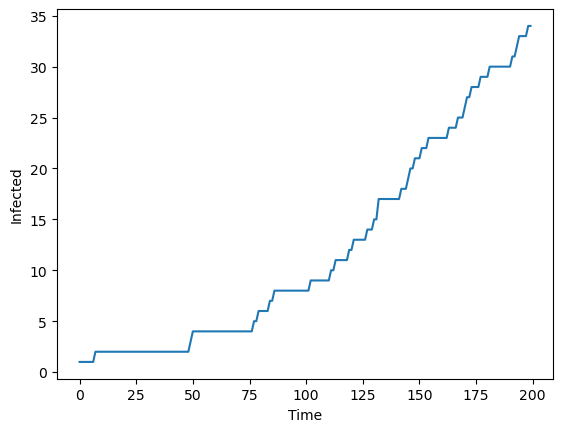

In [10]:
p=Particles(100, scatter=0.02, periodic=True ,seed=321)
p.seed_infection(seeds=[0], dist=0.01)
f=[]
for i in range(200):
    p.walk()
    p.infect()
    f.append(np.sum(p.Infected>0))
plt.figure()
plt.plot(f)
#plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.savefig('movies/InfectionGrowth.png')